<a href="https://colab.research.google.com/github/jej0312/DM_TA/blob/main/3_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering (군집분석)
- TA: 전은지 (Eunji Jeon)  
- Dept. of Industrial Engineering, Yonsei Univ (Industrial Statistics Lab; ISL 산업통계연구실)
- 문의: `jej_0312_@naver.com`

- Unsupervised Learning: Y label이 없는 데이터에서 패턴을 찾는 방법
- Clustering: 거리가 가까운 관측치들 간 유사한 특징이 있을 것이라는 가정을 기반으로 변수들을 군집화
  - 정답이 없으므로 탐색 인사이트 용도로 사용
  - 대부분 optimization 문제를 푸는 경우가 많음
  - 1) 계층적 클러스터링 (hierarchical clustering)과 2) 비계층적 클러스터링(K-means clustering)으로 구분됨
    - 1) 거리행렬을 기반으로 가까운 대상끼리 순차적으로 그룹을 할당
    - 2) 랜덤한 시작점에서 해당 점과 가까운 대상 간 그룹 할당

- 이상치가 존재할 경우 클러스터링 진행 시 영향을 많이 받을 수 있으므로 사전에 제거 과정이 필요

In [13]:
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
import pandas as pd 
data = pd.read_csv('https://raw.githubusercontent.com/jej0312/DM_TA/main/data/fa_data_bfi.csv')

In [15]:
from IPython.display import display
display(data.head())
print('\n', data.shape)

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
0,-0.439830,0.103897,-1.216713,-0.696215,-1.519449
1,0.084369,0.559311,-0.601521,-0.189341,-0.248384
2,0.520534,0.318235,0.025646,-0.751136,0.204503
3,-0.197064,0.057696,-1.019263,0.064286,-1.029492
4,-0.329835,0.408754,-0.058843,-0.820454,-0.691042



 (2436, 5)


In [16]:
# 이상치 제거 함수 (1Q - 1.5*IQR, 3Q + 1.5*IQR 을 넘어가는 값을 가진 행을 제거)
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [17]:
for col in data.columns:
    outlier_idx = get_outlier(df=data, column=col, weight=1.5)
    data.drop(outlier_idx, axis=0, inplace=True)

In [18]:
display(data.head())
print('\n', data.shape)

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
0,-0.439830,0.103897,-1.216713,-0.696215,-1.519449
1,0.084369,0.559311,-0.601521,-0.189341,-0.248384
2,0.520534,0.318235,0.025646,-0.751136,0.204503
3,-0.197064,0.057696,-1.019263,0.064286,-1.029492
4,-0.329835,0.408754,-0.058843,-0.820454,-0.691042



 (2335, 5)


- large scale 데이터를 사용할 경우 계산량이 많아지며, 클러스터링 시 값의 range의 영향을 받기 때문에 표준화/scaling이 필요

In [19]:
data.describe() # 기초통계량

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,0.003113,0.030340,0.025799,0.054182,0.003259
std,0.913940,0.836298,0.821891,0.764686,0.808914
min,-2.011680,-2.287489,-2.320576,-2.107187,-2.294768
25%,-0.718653,-0.498024,-0.526410,-0.439648,-0.570231
50%,-0.056327,0.097684,0.088043,0.142092,0.025512
75%,0.650523,0.655036,0.634843,0.614244,0.609261
max,2.551124,2.336969,1.893386,2.179653,2.011314


In [20]:
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(data)

In [21]:
scaled = pd.DataFrame(scaled, columns = data.columns)
scaled.describe() # 기초통계량

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess
count,2.335000e+03,2.335000e+03,2.335000e+03,2.335000e+03,2.335000e+03
mean,-1.435920e-17,-1.359845e-17,4.052195e-17,1.141129e-18,5.230173e-17
std,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00
min,-2.204987e+00,-2.772128e+00,-2.855461e+00,-2.827083e+00,-2.841488e+00
25%,-7.899000e-01,-6.319241e-01,-6.720208e-01,-6.459321e-01,-7.091154e-01
50%,-6.505121e-02,8.054349e-02,7.574925e-02,1.149865e-01,2.751602e-02
75%,7.085238e-01,7.471380e-01,7.411858e-01,7.325648e-01,7.493164e-01
max,2.788539e+00,2.758732e+00,2.272792e+00,2.780129e+00,2.482941e+00


# 계층적 클러스터링 (Hierarchical Clustering)
- 거리 행렬을 기반으로 유사한 관측치끼리 묶음
  - 모든 관측치들 간 거리를 계산함
- 거리를 어떻게 계산할지에 따라 linkage method 구분  
  1) 최단연결법 (single): 생성된 군집에서 중심과 거리가 **가까운** 관측치끼리 군집화  
  2) 최장연결법 (complete): 생성된 군집에서 중심과 거리가 **먼** 관측치끼리 군집화  
  3) 평균연결법 (average): 군집 내 모든 데이터와 다른 군집 내 모든 데이터 간의 거리 **평균**을 계산하여 군집화  
  4) 중앙연결법 (centroid): 군집 내 **centroid**과 다른 군집 내 median까지의 거리를 계산하여 가까운 것끼리 군집화  
$$\vec{\mu}(\omega_i)\cdot\vec{\mu}(\omega_j)=(\frac{1}{N_i}\sum_{d_m\in\omega_i}\vec{d_m})\cdot(\frac{1}{N_j}\sum_{d_n\in\omega_j}\vec{d_n})=\frac{1}{N_i}\frac{1}{N_j}\sum_{d_m\in\omega_i}\sum_{d_n\in\omega_j}{\vec{d_m}\cdot\vec{d_n}}$$
  5) 와드연결법 (ward): 거리가 아닌, 군집 내 오차 제곱합(within group sum of squares)이 최소가 되도록 최소가 되도록 군집화
$$SSE=\sum^K_{i=1}SSE_i=\sum^{K}_{i=1}\sum^{n_i}_{j=1}\sum^{m}_{k=1}(x_{ijk}-\bar{x}_{ik})^2$$

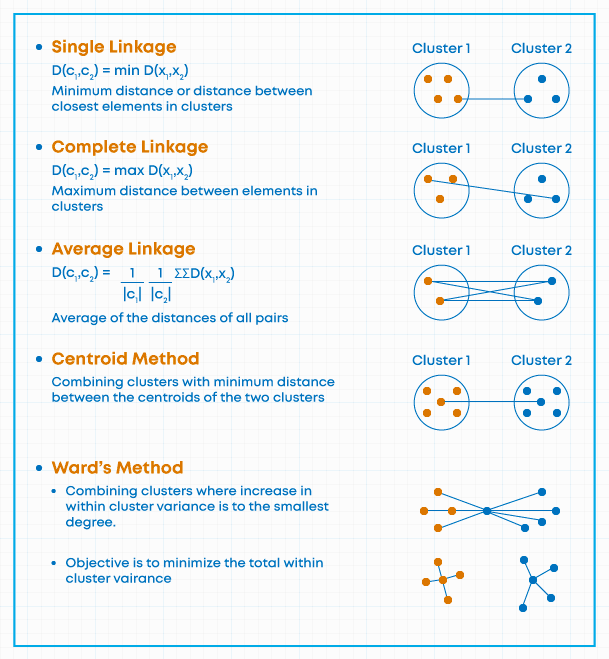
- [출처](https://dataaspirant.com/hierarchical-clustering-algorithm/)

- 장점
    - 클러스터 생성 과정에 대해 이해할 수 있음
    - 사전에 클러스터의 수를 지정하지 않아도 됨
    - 덴드로그램을 통해 클러스터의 수를 결정하는 과정이 쉬움
- 한계
    - 방대한 양의 데이터에서 제대로 작동하지 않을 수 있음
    - 두 클러스터를 결합한 이후에는 그 전으로 돌아갈 수 없음
    - 노이즈 및 이상값에 대해 민감
    - 데이터의 순서가 최종 결과에 영향을 줄 수 있음
- [참고](https://dataaspirant.com/hierarchical-clustering-algorithm/)

## Step 1. 거리 계산에 따른 클러스터링
- `scipy.cluster.hierarchy`의 `linkage` 사용
- [제공하는 linkage 방식](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
  -  single, complete, average, centroid, median, ward, weighted
- [제공하는 거리 계산 방식](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)
  - euclidean distance: real-valued 차원에서 각 관측치들의 location을 기반으로 측정 (Euclidean, manhattan, ...)
    - centroid, median, ward linkage method를 사용할 경우 Euclidean pairwise metric만 활용 가능
  - non-euclidean distance: 각 관측치의 거리가 아닌, properties에 의해 측정 (e.g. cosine, jaccard, ...) 
    - 이 외에 clustroid 등의 method를 사용할 때 사용 가능

In [22]:
data_prime = scaled.copy()

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters = linkage(y=data_prime, method='complete', metric='euclidean')

## Step 2. 군집 수 결정
- 덴드로그램 (dendrogram): 각 단계에서 군집이 어떻게 형성되는지 확인하고 형성된 군집의 유사성(또는 거리) 수준을 평가  
  - 덴드로그램을 더 높게 커팅할수록 최종 군집 수는 더 작지만 유사성 수준은 더 낮아짐
  - 덴드로그램을 더 낮게 커팅할수록 유사성 수준은 더 높지만 최종 군집 수는 더 많아짐
  - 일부 데이터 집합의 경우 평균, 중심, 중위수 및 Ward의 연결 방법으로 계층적 덴드로그램이 생성되지 않음. (결합 거리가 각 단계에서 항상 증가하지 않을 수 있음)

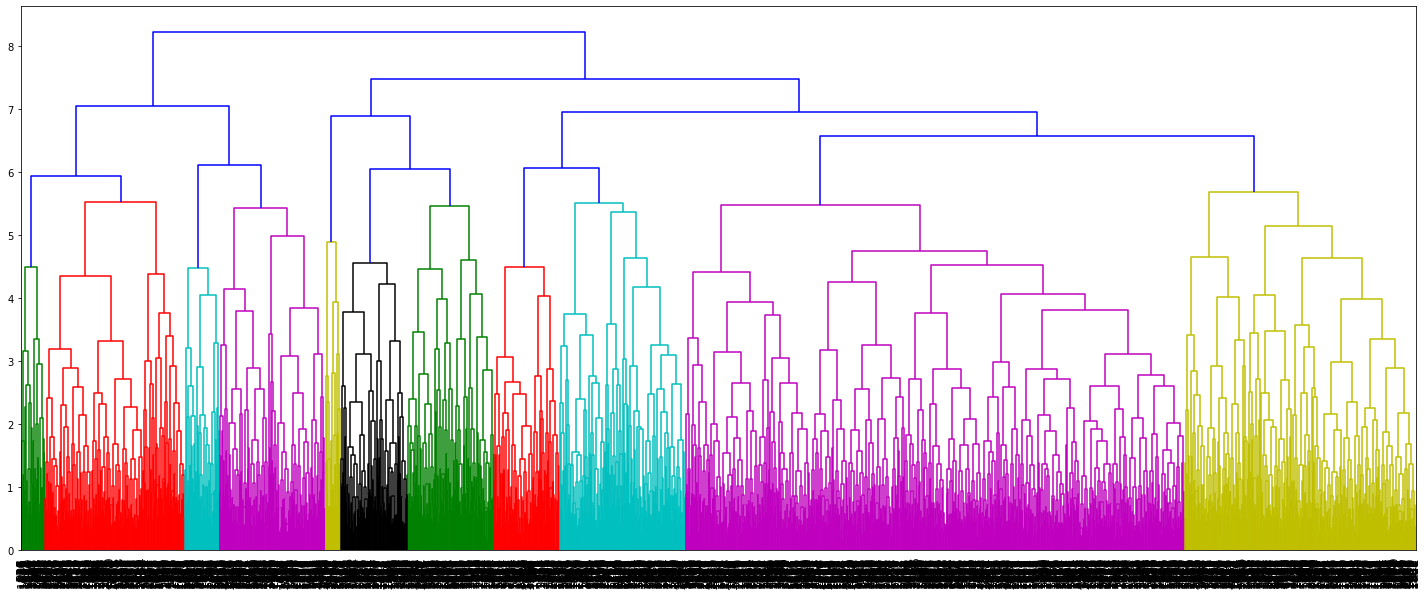

In [24]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
plt.show()

- [`fcluster`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html)을 사용하여 덴드로그램 결과에 기반한 clustering을 진행
- 일반적으로는 (cophenetic)`'distance'` threshold(t)를 기준으로 구분
  - 이 외에도 inconsistent, maxclust, ... 등의 방식이 있음

In [25]:
cut_tree = fcluster(clusters, t=7, criterion='distance')
cut_tree

array([1, 4, 3, ..., 3, 3, 3], dtype=int32)

In [26]:
pd.Series(cut_tree).value_counts()

4    1542
3     283
1     275
2     235
dtype: int64

## Step 3. Evaluation
- 군집 내 비유사성 (within dissimilarities)는 작고 군집 간 비유사성 (between dissimilarities)는 크도록 생성
- 이 때, Silhouette coefficient (실루엣 계수)는 각 관측치와 주위 관측치과의 거리 계산을 통해 군집 내 비유사성과 군집 간 비유사성의 정도를 평가
  - 데이터 양이 많아질수록 time complexity가 높음
  - 구체적인 계산과정은 [다음](https://studying-haeung.tistory.com/10)을 참고

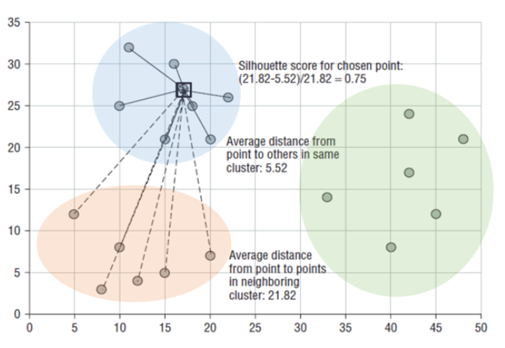
- [출처](https://ariz1623.tistory.com/224)

- `silhouette_samples`를 통해 coefficient를 계산, `silhouette_score`를 통해 모든 coefficient의 평균을 계산

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score
score_samples = silhouette_samples(data_prime, cut_tree)
print('Silhouette Score:', score_samples[:5], '\nSilhouette Score shape:', score_samples.shape, '\n')

average_score = silhouette_score(data_prime, cut_tree)
# np.mean(score_samples) == average_score: True
print('Silhouette Average Score:{0:.3f}'.format(average_score))

Silhouette Score: [0.26399624 0.04965367 0.02685061 0.23496799 0.11082033] 
Silhouette Score shape: (2335,) 

Silhouette Average Score:0.059


1. 전체 실루엣 계수(0~1)의 평균값이 1에 가까울수록 클러스터링이 잘 진행된 것  

|Range of SC|Interpretation|
|:------:|:---------------:|
|0.71-1.0|A strong structure has been found|
|0.51-0.70|A reasonable structure has been found|
|0.26-0.50|The structure is weak and could be artificial|
|< 0.25|No substantial structure has been found|

1. 개별 클러스터의 실루엣 계수 평균값의 편차가 작아야 함
  - 클러스터 내 실루엣 계수 평균값을 확인하여, 1에 가까운 클러스터를 'clear-cut cluster', 0에 가까운 클러스터를 'weak cluster'로 표현

In [28]:
data_prime['hc_cluster'] = cut_tree
data_prime['silhouette_coeff'] = score_samples
data_prime

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,hc_cluster,silhouette_coeff
0,-0.484757,0.087974,-1.512096,-0.981524,-1.882814,1,0.263996
1,0.088926,0.632650,-0.763428,-0.318530,-0.311154,4,0.049654
2,0.566265,0.344323,-0.000187,-1.053360,0.248836,3,0.026851
3,-0.219074,0.032717,-1.271806,0.013216,-1.276987,1,0.234968
4,-0.364378,0.452584,-0.103007,-1.144029,-0.858497,1,0.110820
...,...,...,...,...,...,...,...
2330,1.192595,1.276914,-0.168496,-0.098960,-1.108426,4,0.041472
2331,1.428117,-1.414563,-0.158201,-1.570383,0.505457,3,0.027685
2332,0.798209,0.265352,-0.746378,-0.486530,1.264070,3,-0.045137
2333,-0.247750,0.826233,0.926490,-1.455368,1.139852,3,0.096256


In [29]:
# 군집별 평균 silhouette_score 값
print(data_prime.groupby('hc_cluster')['silhouette_coeff'].mean())
print('표준편차:', data_prime.groupby('hc_cluster')['silhouette_coeff'].mean().std())

hc_cluster
1    0.155768
2    0.082219
3    0.057706
4    0.038121
Name: silhouette_coeff, dtype: float64
표준편차: 0.05147475615133177


## Step 4. EDA/Interpretation

In [30]:
# 군집별 통계(평균)
cluster_g = data_prime.groupby('hc_cluster')
cluster_g.mean()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,silhouette_coeff
hc_cluster,,,,,,
1,-0.202224,-0.476430,-0.354750,0.008229,-1.193593,0.155768
2,0.641531,-0.987144,0.818133,0.047872,0.429910,0.082219
3,-0.202057,-0.504072,-0.200515,-1.428871,0.369076,0.057706
4,-0.024621,0.327918,-0.024617,0.253474,0.079611,0.038121


In [31]:
# 군집별 통계(표준편차)
cluster_g.std()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,silhouette_coeff
hc_cluster,,,,,,
1,0.961289,0.731722,1.000291,0.855926,0.599619,0.090031
2,0.898211,0.795442,0.797586,0.970096,1.129314,0.121418
3,0.873832,1.061641,1.110190,0.690878,1.062821,0.136505
4,1.005253,0.879968,0.939506,0.845658,0.858583,0.126445


- Cluster1: 개방적이지 않은(-O) 사람
- Cluster2: 신경질적(N)인데 외향적이지 않으며(-E) 성실한(C) 사람
- Cluster3: 쾌활하지 않은(-A) 사람
- Cluster4: 큰 특징이 존재하지 않는 사람

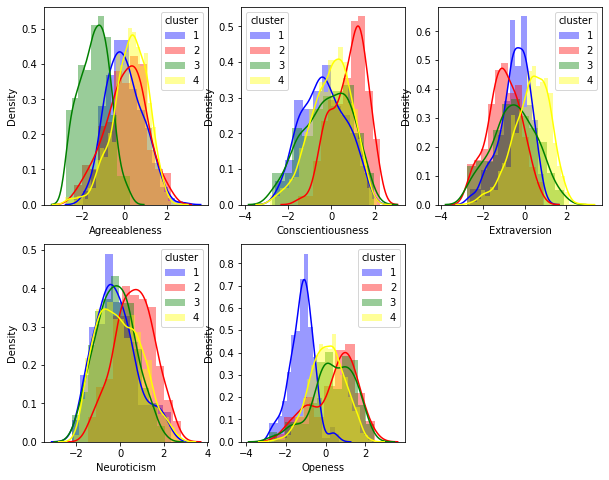

In [ ]:
# 시각화방법 1
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) 
plt.subplot(2,3,1) 
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Agreeableness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Agreeableness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Agreeableness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Agreeableness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,2) 
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Conscientiousness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Conscientiousness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Conscientiousness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Conscientiousness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,3)
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Extraversion"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Extraversion"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Extraversion"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Extraversion"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,4)
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Neuroticism"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Neuroticism"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Neuroticism"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Neuroticism"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.subplot(2,3,5)
sns.distplot(data_prime[data_prime.hc_cluster == 1]["Openess"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.hc_cluster == 2]["Openess"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.hc_cluster == 3]["Openess"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.hc_cluster == 4]["Openess"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.show()

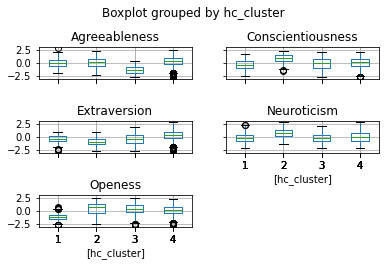

In [ ]:
# 시각화방법 2
import matplotlib.pyplot as plt
data_prime.drop('silhouette_coeff', axis=1).boxplot(by='hc_cluster')
plt.tight_layout(pad=3, h_pad=1)
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


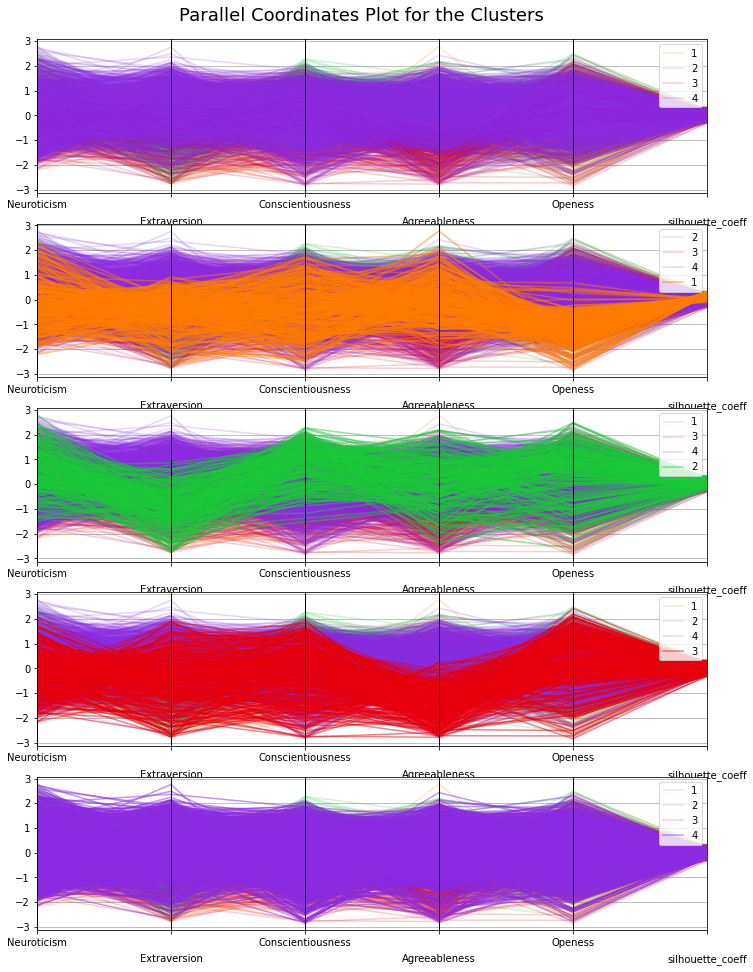

In [37]:
# Display parallel coordinates plots, one for each cluster
'''https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/3b.%20Hierarchical%20Clustering.ipynb'''
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
palette = sns.color_palette("bright", 10)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    def addAlpha(colour, alpha):
        '''Add an alpha to the RGB colour'''
        
        return (colour[0],colour[1],colour[2],alpha)

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.hc_cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'hc_cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'hc_cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        

display_parallel_coordinates(data_prime, 5) # cluster 0 포함 개수

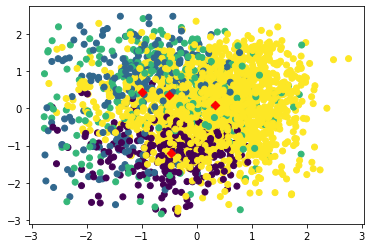

In [ ]:
# 시각화방법 3
plt.scatter(x=data_prime['Extraversion'], y=data_prime['Openess'], c=data_prime['hc_cluster']) # 각 cluster 좌푯값 시각화

hc_centers = np.array(cluster_g.mean()) # 각 cluster별 centroid
plt.scatter(x=hc_centers[:,1], y=hc_centers[:,4], marker='D', c='r') # 각 cluster별 centroid 시각화
# marker='D', c='r' : 마커 모양은 Diamond, 색깔은 red
plt.set_xlabel('Extraversion', rotation=150)
plt.set_ylabel('Openess')
plt.show()

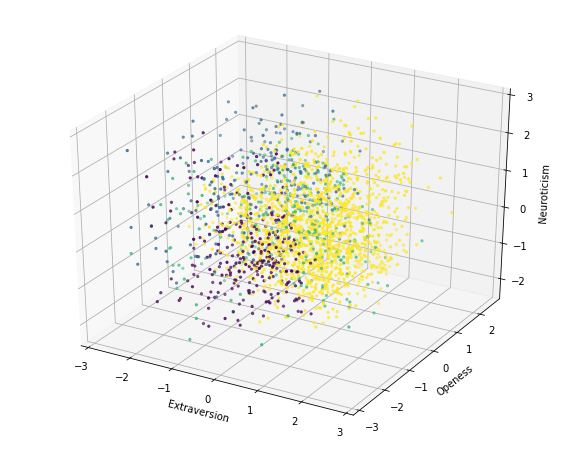

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection = '3d')

ax.scatter(data_prime['Extraversion'], data_prime['Openess'], data_prime['Neuroticism'], s=5, c = data_prime['hc_cluster'])
ax.set_xlabel('Extraversion', rotation=150)
ax.set_ylabel('Openess')
ax.set_zlabel(r'Neuroticism', rotation=60)
plt.show()

# k-평균 클러스터링 (K-means Clustering)
- Euclidean space를 가정
- [과정](https://eunsukimme.github.io/ml/2019/12/16/K-Means/)  
  1) 클러스터의 개수 k를 선정  
  2) 데이터셋에서 k개의 centroids를 임의로 지정  
  3) 각 데이터들을 가장 가까운 centroids가 속한 그룹에 할당  
  4) 각 클러스터의 centroids 다시 계산 (일반적으로 유클리드 거리 사용)  
  5) 3, 4번 과정을 centroids가 더 이상 변하지 않을 때까지/지정된 횟수까지 반복  

- [한계](https://medium.com/h-document/%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81-%EA%B5%B0%EC%A7%91-%EB%B6%84%EC%84%9D-%EB%B9%84-%EA%B3%84%EC%B8%B5%EC%A0%81-%EA%B5%B0%EC%A7%91-%EB%B6%84%EC%84%9D-ef1a96948d7d)
  - K 결정이 주관적
  - 여러 초기값이 동일 군집에 존재할 경우 최종 결과가 이상해질 수 있음
  - 크기가 작은 그룹에서는 제대로 작동하지 않을 수 있음
  - 반복 특성과 centroid를 random하게 초기화하기 때문에 local optimum에 고착, global optimum에 수렴되지 않을 수 있음

- Extensions
    - k-means에서 initial points로 비슷한 점들이 여러 개 선택되는 경우 불안정한 군집을 학습하게 됨 ([자세한 과정](https://lovit.github.io/nlp/machine%20learning/2018/03/19/kmeans_initializer/))
    - `k-means++`: 1) 첫 initial point를 임의로 선택, 2) 이후의 initial points는 과거 initial points와 멀리 떨어지도록 분포를 조절하여 진행
        - 문서의 bag of words와 같이, 고차원의 sparse 데이터를 군집화하는 과정에서, 대부분의 데이터 간 거리가 유사할 경우 k-means++를 적용하는 것은 expensive한 버전의 random sampling을 수행하는 것과 같음
    - `SphericalKMeans`: k-means++가 가지는 한계를 완화하기 위해 등장. 2)에서 다음 initial points가 멀리 떨어지도록 조절하는 과정에서 거리가 threshold 이하인 점들을 제거 후 random하게 initial points 선택
    - k-medoid: 임의의 점으로 초기화하는 kmeans와 달리 특정 점을 medoid로 사용  
      - large data에 잘 먹지 않을 수 있음
    - fuzzy c-means clustering (soft clustering)


In [38]:
data_prime = scaled.copy()

## Step 1. K 선정
1. EDA: 데이터의 형태를 살펴보고 manually 결정  
2. Elbow method: 클러스터의 개수를 늘려가며 SSE를 계산, SSE가 줄어드는 비율이 급격히 작아지는 부분을 elbow라 설정  
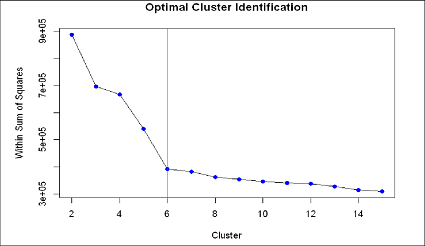
3. Silhouette score
4. Calinski Harabasz score: Variance Ratio Criterio이라고도 알려짐. between-clusters dispersion mean 과 within-cluster dispersion의 비율. 값이 높을수록 군집화가 잘 되었음을 의미
- 기타 지표 [참고](https://hongl.tistory.com/161)

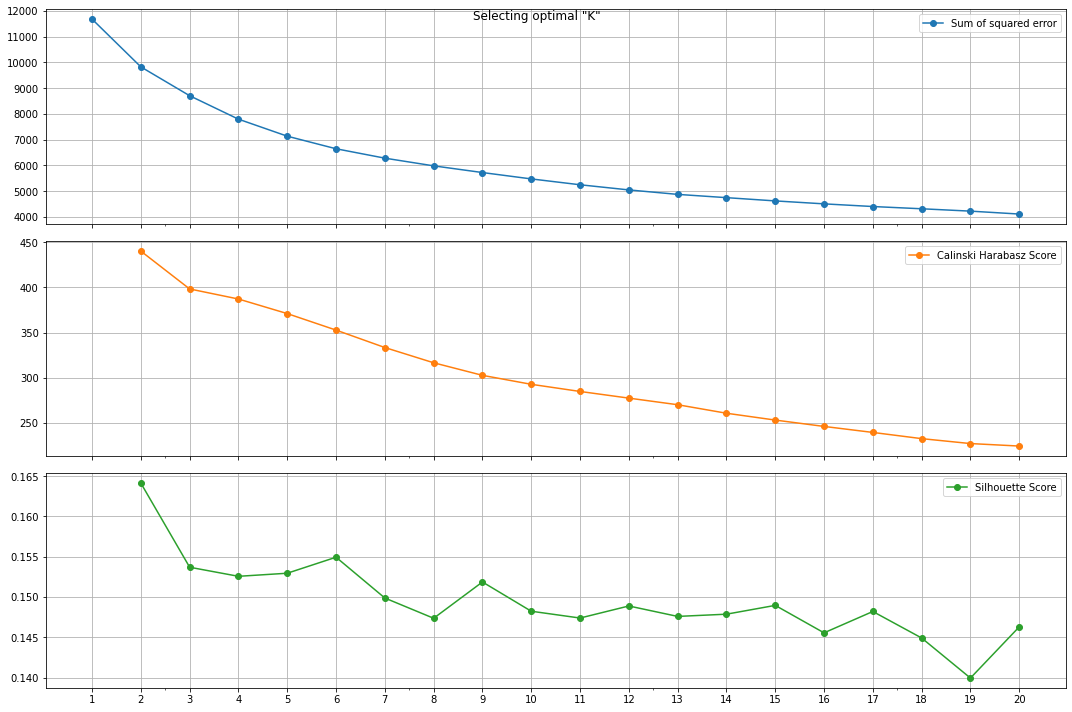

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

search_range = range(1, 21)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(data_prime)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(data_prime)
        chs = calinski_harabasz_score(data_prime, cluster)
        ss = silhouette_score(data_prime, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

## Step 2. K-means clustering

In [39]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=6, random_state=312, algorithm='auto')
model.fit(data_prime)

KMeans(n_clusters=6, random_state=312)

In [40]:
# 각 군집(cluster) 표시
pred = model.predict(data_prime)
pred

array([3, 3, 3, ..., 4, 2, 5], dtype=int32)

In [41]:
# 군집별 centroids의 좌표값
centroids = model.cluster_centers_
centroids = pd.DataFrame(centroids, columns = data_prime.columns)

## Step 3. Evaluation

In [43]:
from sklearn.metrics import silhouette_samples, silhouette_score
data_prime['k_means_cluster'] = pred
data_prime['k_silhouette_coeff'] = silhouette_samples(data_prime, data_prime['k_means_cluster'])

k_average_score = silhouette_score(data_prime, data_prime['k_means_cluster'])
print('Average Silhouette Score:{0:.3f}'.format(k_average_score))

Average Silhouette Score:0.282


In [44]:
# 군집별 평균 silhouette_score 값
data_prime.groupby('k_means_cluster')['k_silhouette_coeff'].mean()

k_means_cluster
0    0.315697
1    0.212215
2    0.352969
3    0.232669
4    0.274355
5    0.269768
Name: k_silhouette_coeff, dtype: float64

## Step 4. EDA/Interpretation

In [45]:
# 군집별 통계
data_prime.groupby('k_means_cluster').mean()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,k_silhouette_coeff
k_means_cluster,,,,,,
0,1.194660,0.469680,0.591030,0.303038,0.222898,0.315697
1,-0.116738,-0.855294,0.064214,0.362069,-1.072474,0.212215
2,-0.862055,0.515015,0.666027,0.457621,0.314539,0.352969
3,0.155030,0.390501,-0.503809,-1.002452,-0.800176,0.232669
4,-0.061333,0.260201,-1.203643,0.588691,0.481416,0.274355
5,0.102463,-1.154615,0.068959,-1.071206,0.821108,0.269768


- Cluster0: 신경질적이고(N) 성실한(C) 사람
- Cluster1: 외향적이지 않고(-E) 개방적이지 않은(-O) 사람
- Cluster2: 신경질적이지 않고(-N) 성실한(C) 사람
- Cluster3: 쾌활하지 않고(-A) 개방적이지 않은(-O) 사람
- Cluster4: 성실하지 않고(-C) 쾌활한(A) 사람
- Cluster5: 외향적이지 않고(-E) 쾌할하지 않으며(-A) 개방적인(O) 사람

In [ ]:
data_prime.groupby('k_means_cluster').std()

,Neuroticism,Extraversion,Conscientiousness,Agreeableness,Openess,k_silhouette_coeff
k_means_cluster,,,,,,
0,0.632436,0.791853,0.728553,0.726885,0.807650,0.085204
1,0.863435,0.730921,0.907754,0.742576,0.697098,0.092622
2,0.540601,0.668727,0.565232,0.706372,0.723647,0.099510
3,0.860787,0.751342,0.841463,0.718497,0.746022,0.096106
4,0.861366,0.837261,0.647819,0.689873,0.731363,0.085374
5,0.908411,0.783440,0.892233,0.877511,0.785956,0.091473


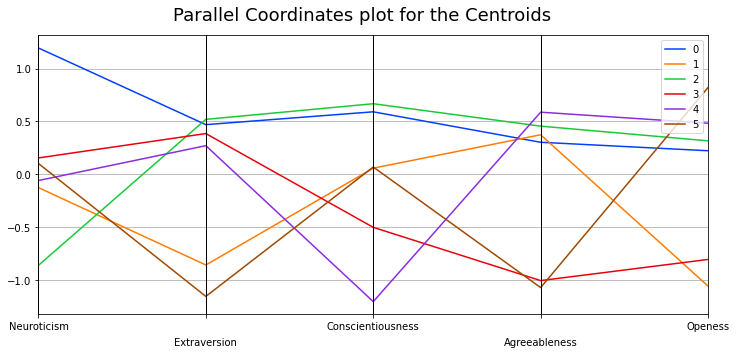

In [47]:
# Create a data frame containing our centroids
'''https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/3a.%20K-Means%20Clustering.ipynb'''
centroids['cluster'] = centroids.index

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

display_parallel_coordinates_centroids(centroids, 5)

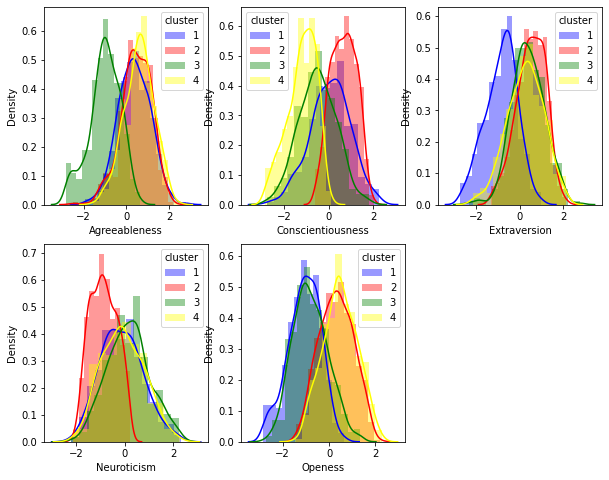

In [ ]:
# 시각화방법 1
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) 
plt.subplot(2,3,1) 
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Agreeableness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Agreeableness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Agreeableness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Agreeableness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,2) 
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Conscientiousness"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Conscientiousness"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Conscientiousness"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Conscientiousness"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,3)
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Extraversion"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Extraversion"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Extraversion"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Extraversion"], 
             color="yellow", label=4)
plt.legend(title="cluster")


plt.subplot(2,3,4)
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Neuroticism"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Neuroticism"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Neuroticism"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Neuroticism"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.subplot(2,3,5)
sns.distplot(data_prime[data_prime.k_means_cluster == 1]["Openess"], 
             color="blue", label=1)
sns.distplot(data_prime[data_prime.k_means_cluster == 2]["Openess"], 
             color="red", label=2)
sns.distplot(data_prime[data_prime.k_means_cluster == 3]["Openess"], 
             color="green", label=3)
sns.distplot(data_prime[data_prime.k_means_cluster == 4]["Openess"], 
             color="yellow", label=4)
plt.legend(title="cluster")

plt.show()

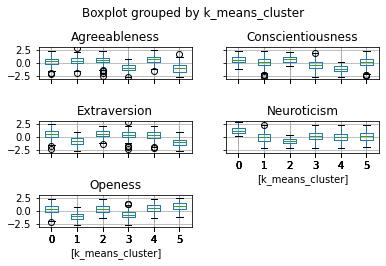

In [ ]:
# 시각화방법 2
data_prime.drop('k_silhouette_coeff', axis=1).boxplot(by='k_means_cluster')
plt.tight_layout(pad=3, h_pad=1)
plt.show()

Text(0, 0.5, 'Agreeableness')

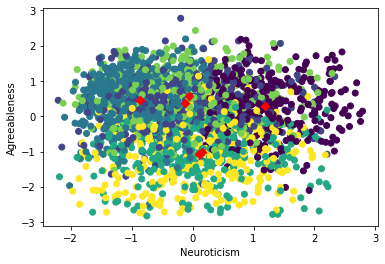

In [ ]:
# 군집결과 시각화
plt.scatter(x=data_prime['Neuroticism'], y=data_prime['Agreeableness'], c=data_prime['k_means_cluster'])
plt.scatter(x=centers[:,0], y=centers[:,3], marker='D', c='r') # x, y는 각각 factor 1번째(0)와 4번째(3)
plt.xlabel('Neuroticism')
plt.ylabel('Agreeableness')

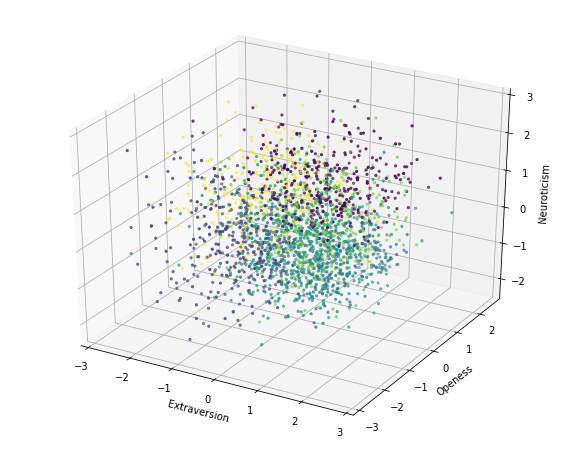

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection = '3d')

ax.scatter(data_prime['Extraversion'], data_prime['Openess'], data_prime['Neuroticism'], s=5, c = data_prime['k_means_cluster'])
ax.set_xlabel('Extraversion', rotation=150)
ax.set_ylabel('Openess')
ax.set_zlabel(r'Neuroticism', rotation=60)
plt.show()

# Appendices
## Density-based Clustering
### DBSCAN(1996, Ester et al.)
- 데이터의 밀도가 임계값보다 높은 부분을 클러스터로, 그 외는 노이즈로 두는 알고리즘 
- 가정
  - 높은 density를 가진 관측치들 간 클러스터를 구성
  - 노이즈 근처의 density는 낮을 것
- 장점
  - 노이즈의 존재를 허용
  - 구형이 아닌 다양한 형태의 클러스터를 찾아낼 수 있음  
  - 클러스터의 개수를 파라미터로 지정하지 않음  

- 범주형 변수가 존재하는 경우 ([참고](https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086))
  - 거리를 측정하는 클러스터링을 위해 범주형 변수는 제외하거나 연속형 변수로 형태를 변경해주어야 함
    - one-hot encoding
  - K-modes, k-prototypes 방법 등을 고려

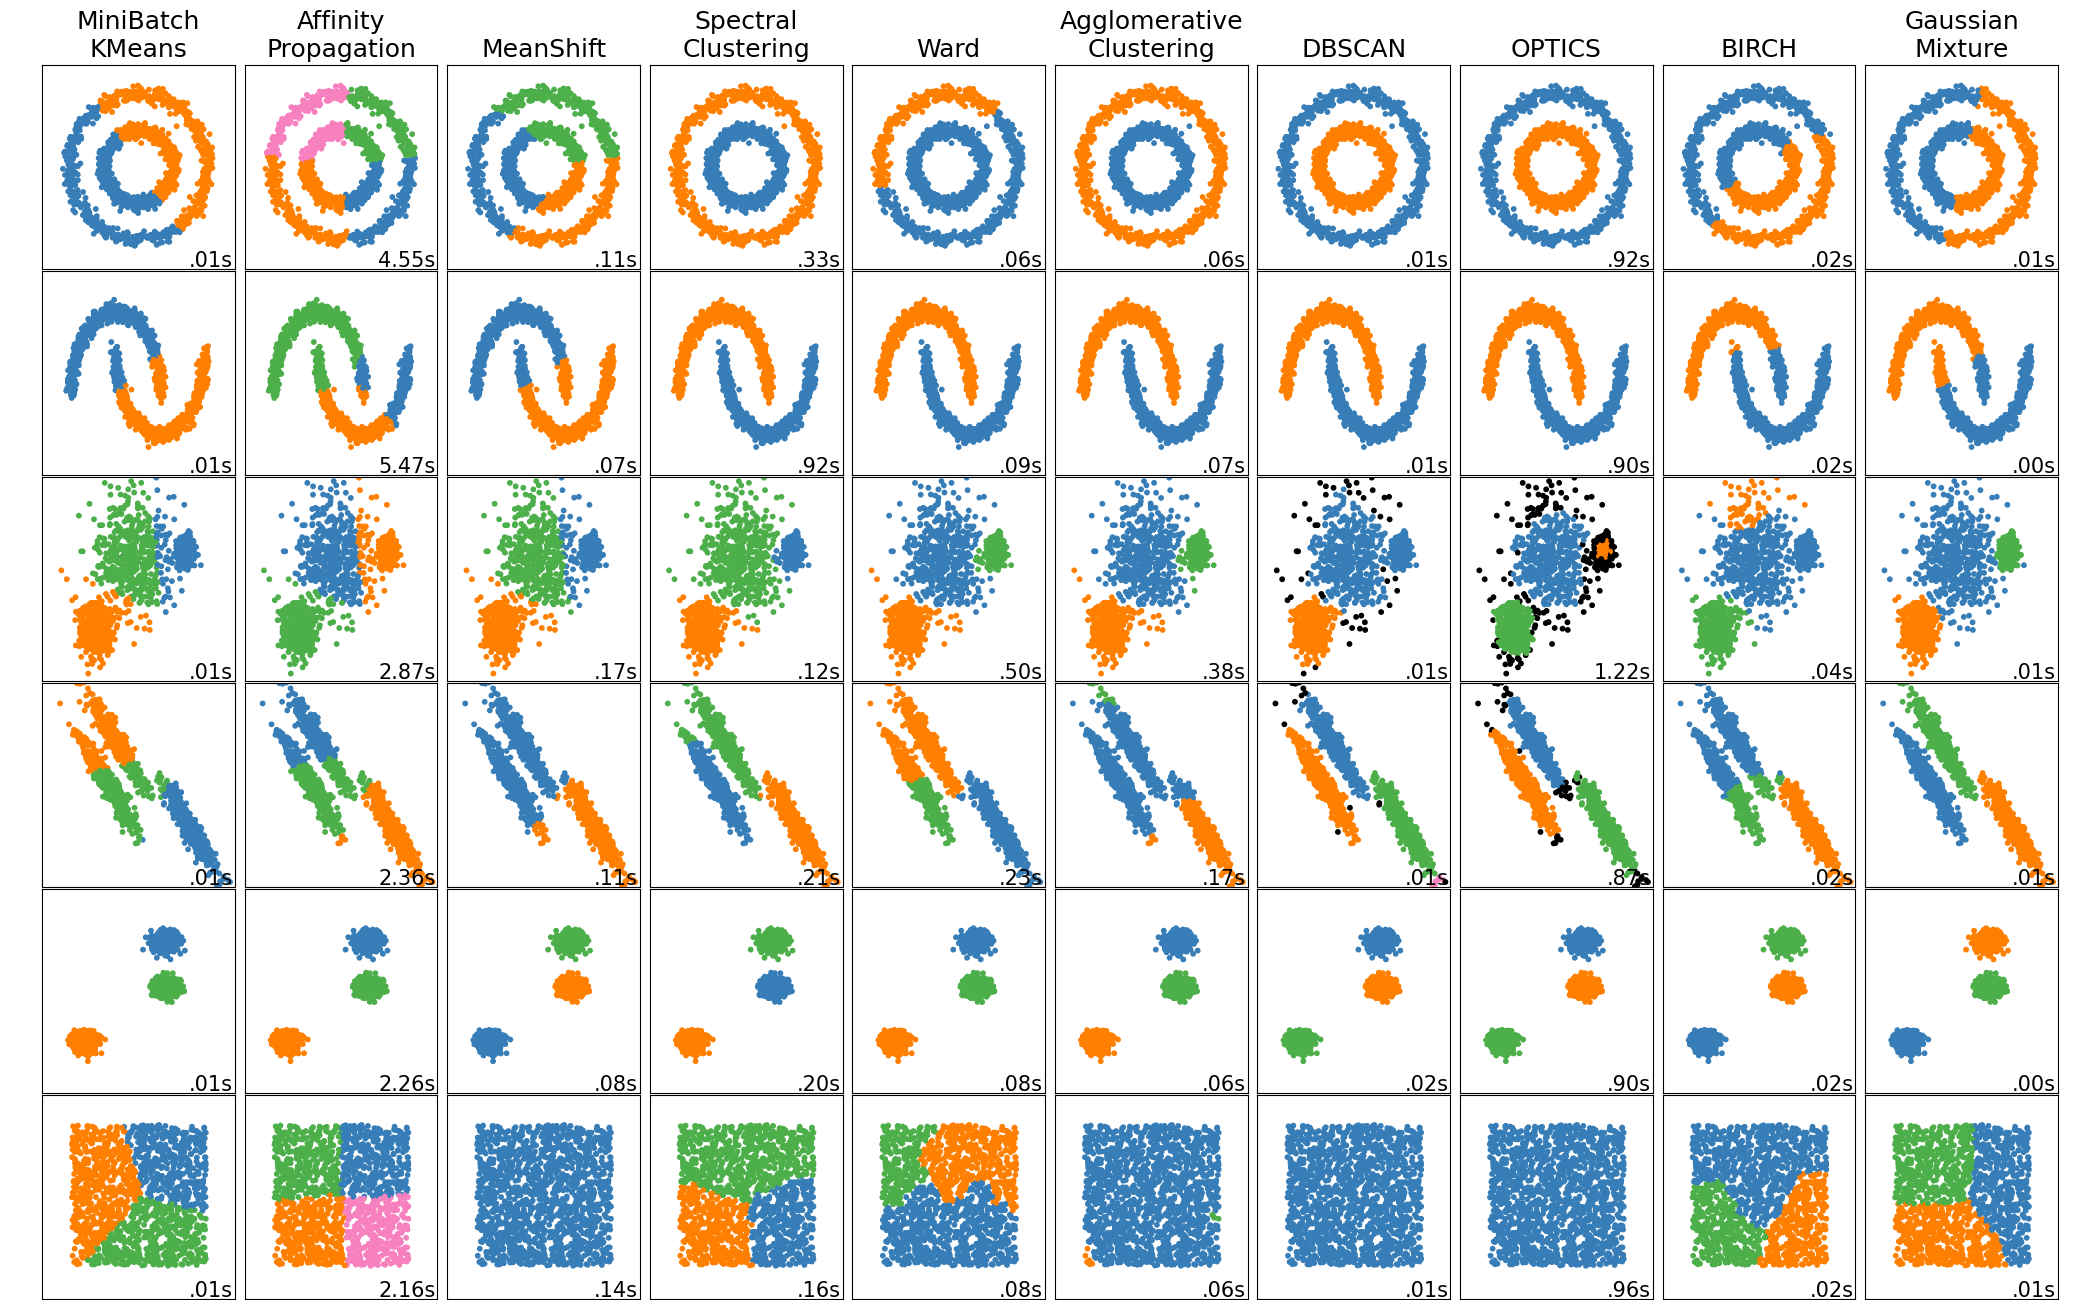

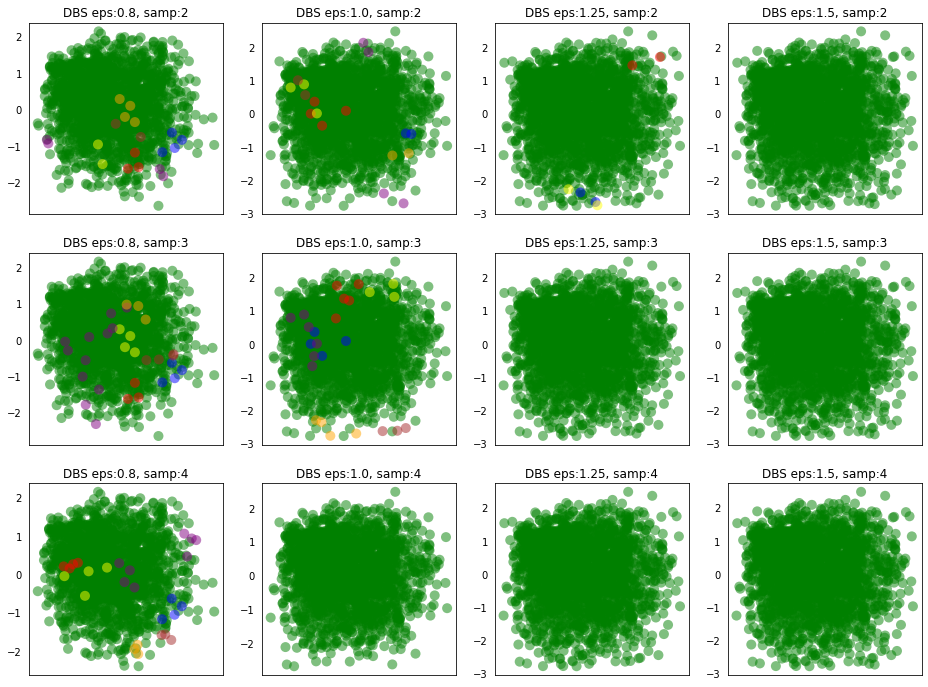

In [ ]:
from sklearn.cluster import DBSCAN
import math
from itertools import product

'''
https://github.com/dougfoo/machineLearning/blob/master/covid/COVID-global-clustering.ipynb
'''

samp_list = [2, 3, 4]
eps_list = [0.8, 1.0, 1.25, 1.5]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(16,12))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    PCA_components3 = scaled.copy() # 데이터 입력

    ax[k%rows][math.floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(PCA_components3)
    PCA_components3.insert(0, 'cluster', clustering.labels_)

    datas = []
    for i in range(len(set(clustering.labels_))): 
        tup = [PCA_components3[PCA_components3['cluster']==i].iloc[:, j] for j in [1, 2]] # 2차원으로 표현 => 몇번째 칼럼을 사용할 것인지 [1, 2]: 2번째, 3번째 칼럼
        datas.append(tup)

    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[k%rows][math.floor(k/rows)].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][math.floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')